# MAC0219 / MAC5742

## Programação Concorrente e Paralela

## EP2 - OpenMPI

### Data para entrega: 30/07/2021


### Equipe:

Ciro Batista Rosa, 2320769

Diego Zurita, 10284222

Francisco Edvar da Cunha Filho, 10656115

Pedro Zamecki Andrade, 11207800


### Objetivo

O objetivo proposto pelo EP2 é "utilizar a experiência com análise de desempenho de programas paralelos, adquirida no EP1, para planejar e analisar experimentos para determinar parâmetros de configuração de implementações
OpenMPI (OMPI) do cálculo do fractal de Mandelbrot."


### Introdução

Este trabalho analisa seis implementações diferentes de código (uma sequncial e cinco paralelizáveis) elaboradas a partir de bibliotecas em C das implementações de Pthreads, OpenMP e OpenMPI. O tempo de execução é tomado como principal figura de mérito de desempenho para cada implementação. Considerações específicas ao OpenMPI são feitas, devido ao resultado significativamente inferior obtido em relação à versão sequencial.


### Descrição das atividades

**a. Equipamento**

O experimento foi rodado em máquina com as seguintes características:
* Notebook Dell 7460, core i7, 4 cores
* GPU NVidia GeForce 940MX
* 8 GB RAM
* 16 GB Swap
* Linux Ubuntu-Mate 20.04 nativo

**b. Elaboração de códigos em C**

Um total de seis arquivo contendo os códigos-fonte requeridos são entregues em arquivo ZIP como parte deste trabalho, podendo ser compilados com seu respectivo Makefile, também em anexo. Seus títulos são auto-explicativos e os detalhes de cada implementação podem ser verificados no próprio código-fonte:

* mandelbrot_seq.c
* mandelbrot_pth.c
* mandelbrot_omp.c
* mandelbrot_mpi.c
* mandelbrot_mpi_pth.c
* mandelbrot_mpi_omp.c

**c. Execução dos experimentos**

Cada executável correspondente aos códigos acima foi executado por 15 vezes para medição do tempo de execução, utilizando-se o comando "perf stat", para a região de Mandelbrot identificada como "Triple Spiral Valley", e para um tamanho de imagem definido pelo enunciado como uma matriz de 4096x4096 pontos. Dois números em específico são extraídos da saída do comando e utilizados neste trabalho: o "time elapsed" e sua respectiva incerteza na medição.

De modo a automatizar os experimentos, o código Python a seguir foi preparado de modo a assegurar a execução automática do experimento, como segue:

* Execução de cada rodada com 1, 4, 8, 16, 32 e 64 threads / processos (ver observação);
* Gravação de cada resultado de medição em arquivo texto "output.txt";
* Gravação de cada figura gerada em arquivos individuais com extensão PPM, numerados de forma a corresponder com cada linha da tabela CSV de resultados, como forma de verificação de corretude do código;
* Geração de tabela CSV contendo os parâmetros de cada experimento e os respectivos resultados (time elapsed, e incerteza).

**Observações importantes**

O enunciado faz menção aos termos "número de processos" e "número de threads" de forma ambígua. É entendimento da equipe que ambos os termos são sinônimos, não devendo haver uma distinção entre eles.

Dito isso, cabe aqui ressaltar uma peculiaridade, relativa à chamada das funções mpi_pth e mpi_omp. Estas funções requerem em sua linha de comandos o instanciamento duplo do número de processos (divididos entre mpi e openmp/pthread, conforme o caso). Neste trabalho, a sua SOMA indica o número de threads executados pelo código. Para exemplificar, as três execuções abaixo executam um total de 64 threads:

* mpiexec -np 64 ./mandelbrot_mpi.o -0.188 -0.012 0.554 0.754 4096
* mpiexec -np 8 ./mandelbrot_mpi_pth.o -0.188 -0.012 0.554 0.754 4096 56
* export OMP_NUM_THREADS=56|mpiexec -np 8 ./mandelbrot_mpi_omp.o -0.188 -0.012 0.554 0.754 4096

Vale mencionar que a equipe tomou uma decisão de projeto no sentido de limitar o número de threads programados para openmpi, através do parâmetro -np, em um máximo de 8 threads (-np 8), devido ao grande consumo de memória (RAM e Swap) observado, com um consequente efeito no tempo de execução e até mesmo o travamento completo da máquina por falta de memória, quando este número foi excedido.

Conforme o caso, para até 8 threads, as mesmas foram divididas igualmente entre cada estratégia de paralelismo.


In [ ]:
# libraries
import os
#import sys
import pandas as pd
from time import sleep

# setup experiment
results_filename = "output.txt"
csv_filename = "./experiment_results.csv"

programs = ["./mandelbrot_seq.o",
            "./mandelbrot_pth.o", 
            "./mandelbrot_omp.o",
            "./mandelbrot_mpi.o",
            "./mandelbrot_mpi_pth.o",
            "./mandelbrot_mpi_omp.o"]
            
repetitions = 15
nthreads = [1, 4, 8, 16, 32, 64]
image = "-0.188 -0.012 0.554 0.754"
image_size = 4096

df = pd.DataFrame(data=None, columns=[
                  "program",
                  "repetitions",
                  "threads",
                  "image",
                  "image_size",
                  "time_sec",
                  "time_tolerance_sec",
                  ])

os.system("rm output.txt")


# build commmand header
command_header = "perf stat -r " + str(repetitions)

# build command lines
command_lines = []
for nthread in nthreads:
    nth = int(nthread / 2)

    for program in programs:
        r1 = ("seq" in program) and (nthread > 1)
        r2 = ("mpi.o" in program) and (nthread > 16)
        r3 = ("mpi_pth" in program) and (nthread == 1)
        r4 = ("mpi_omp" in program) and (nthread == 1)

        if r1 or r2 or r3 or r4:
            continue

        if nthread > 8:
            n_mpi = 8
            n_oth = nthread - 8
        else:
            n_mpi = int(nthread / 2)
            n_oth = int(nthread / 2)
        
        prg = program + " " + image + " " + str(image_size)
        
        # mount omp command line preparation
        omp_prep_simple = "export OMP_NUM_THREADS=" + str(nthread) + "|"
        omp_prep_dual   = "export OMP_NUM_THREADS=" + str(n_oth) + "|"

        # mount mpi_command
        mpi_command_simple = "mpiexec -np " + str(nthread)
        mpi_command_dual   = "mpiexec -np " + str(n_mpi)

        # mount pthread command
        pth_command_simple = str(nthread)
        pth_command_dual   = str(n_oth)
        
        if "seq" in program:
            command_line = command_header + " " + prg
        
        elif "mpi_pth" in program:
            command_line = command_header + " " + mpi_command_dual + " " + prg + " " + pth_command_dual
            
        elif "mpi_omp" in program:
            command_line = omp_prep_dual + command_header + " " + mpi_command_dual + " " + prg
        
        elif "mpi" in program:
            command_line = command_header + " " + mpi_command_simple + " " + prg
            
        elif "pth" in program:
            command_line = command_header + " " + prg + " " + pth_command_simple

        elif "omp" in program:
            command_line = omp_prep_simple + command_header + " " + prg

            
        command_lines.append(command_line)
        
        
        # write in pandas
        database_row = {
            "program": program,
            "repetitions": repetitions,
            "threads": nthread,
            "image": image,
            "image_size": image_size
            }
        df = df.append(database_row, ignore_index=True)


# execute all commmand lines
ind = 0
for command_line in command_lines:
    full_command_line = command_line + " >> " + results_filename + " 2>&1"
    print(full_command_line)

    os.system(full_command_line)
    figure_name = str(ind) + ".ppm"
    os.rename("output.ppm", figure_name)
    ind += 1
    sleep(1)


# decode output and store on pandas
ind = 0
f = open(results_filename, 'r')
lines = f.readlines()
for line in lines:
    if "elapsed" in line:
        l = line.split(sep = " ")
        l_short = [x for x in l if x]
        time_seconds = l_short[0]
        time_seconds = time_seconds.replace(",", ".")
        time_seconds = float(time_seconds)
        df.iloc[ind, 5] = time_seconds

        time_tolerance_sec = l_short[2]
        time_tolerance_sec = time_tolerance_sec.replace(",", ".")
        time_tolerance_sec = float(time_tolerance_sec)
        df.iloc[ind, 6] = time_tolerance_sec

        ind += 1


# store df as csv
df.to_csv(csv_filename, index = True, header=True, sep=",")

### Resultados obtidos

A seguir, apresenta-se tabela contendo cada experimento realizado, seus respectivos parâmetros, e resultados:

In [11]:
import pandas as pd
csv_filename = "./experiment_results.csv"
df = pd.read_csv(csv_filename, sep=",")
df

,Unnamed: 0,program,repetitions,threads,image,image_size,time_sec,time_tolerance_sec
0,0,./mandelbrot_seq.o,15,1,-0.188 -0.012 0.554 0.754,4096,21.4668,0.0184
1,1,./mandelbrot_pth.o,15,1,-0.188 -0.012 0.554 0.754,4096,21.4936,0.0131
2,2,./mandelbrot_omp.o,15,1,-0.188 -0.012 0.554 0.754,4096,7.8796,0.0522
3,3,./mandelbrot_mpi.o,15,1,-0.188 -0.012 0.554 0.754,4096,21.6289,0.0137
4,4,./mandelbrot_pth.o,15,4,-0.188 -0.012 0.554 0.754,4096,7.9629,0.0357
5,5,./mandelbrot_omp.o,15,4,-0.188 -0.012 0.554 0.754,4096,7.9919,0.0354
6,6,./mandelbrot_mpi.o,15,4,-0.188 -0.012 0.554 0.754,4096,10.0348,0.0369
7,7,./mandelbrot_mpi_pth.o,15,4,-0.188 -0.012 0.554 0.754,4096,15.8463,0.0552
8,8,./mandelbrot_mpi_omp.o,15,4,-0.188 -0.012 0.554 0.754,4096,15.6507,0.0607
9,9,./mandelbrot_pth.o,15,8,-0.188 -0.012 0.554 0.754,4096,7.7258,0.0222


Além disso, é verificada a corretude dos códigos que geraram cada figura de Mandelbrot, comparando-as com a figura gerada pela versão sequencial (golden sample, ilustrada a seguir). Um resultado TRUE indica que todas as figuras estão corretas.

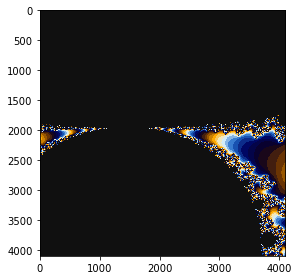

True


In [12]:
import numpy as np
from skimage import io
import os

# get seq figure and show
img_seq = io.imread("0.ppm")
io.imshow(img_seq)
io.show()

# read all ppm files in folder
files = os.listdir()
ppm_files = [f for f in files if ".ppm" in f]

# compare with seq
match_with_seq = []
for f in ppm_files:
    img = io.imread(f)
    check = np.all(img == img_seq)
    match_with_seq.append(check)

# check if all match with seq figure
print(np.all(match_with_seq))

### Discussão dos resultados

Conforme gráfico a seguir, a versão MPI do código obteve resultados melhores que a versão sequencial para até 8 threads. Houve uma degradação significativa em sua performance a partir de 16 threads, e acima disso sua execução tornou-se impossível pelo longo tempo de execução do  algoritmo, causando até mesmo o completo travamento da máquina. A equipe entende que a causa raiz do problema se dá pela forma que a alocação de memória para cada processo é implementada, o que levou (para 16 threads) a um consumo de 100% da memória RAM + 50% de Swap da máquina (verificados pelo comando htop).


Da maneira como implementamos, cada processo mpi é responsável por uma faixa da imagem e, uma vez calculado essa faixa, o processo envia o resultado para o processo 0. Similar ao algoritmo map reduce. Porém como os processos são iguais, cada um deles irá chamar a função `allocate_image_buffer`, consequentemente, alocando a imagem inteira para cada processo e, portanto, consumindo mais memória do que é necessário. Tentamos mudar a maneira como o `allocate_image_buffer` aloca memória, porém, da maneira que pensamos, era necessário alterar praticamente o código-fonte inteiro, então foi uma decisão de projeto manter a mesma alocação com trade-off de consumir mais memória.

### Conclusões

bla bla bla

### Referências

https://phrb.github.io/PPD/lectures/tex/pthreads_omp/index.html

https://hpc-tutorials.llnl.gov/mpi/